<a href="https://colab.research.google.com/github/Aish280405/hyperspectral-classification/blob/main/hyperspectral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD

In [ ]:
def load_data():
    data = sio.loadmat('salinas_corrected.mat')['salinas_corrected']
    labels = sio.loadmat('salinas_gt.mat')['salinas_gt']
    return data, labels

In [ ]:
def apply_pca(X, n_components=30):
    reshaped = X.reshape(-1, X.shape[2])
    pca = PCA(n_components=n_components, whiten=True)
    X_pca = pca.fit_transform(reshaped)
    X_pca = X_pca.reshape(X.shape[0], X.shape[1], n_components)
    return X_pca

In [ ]:
def pad_with_zeros(X, margin):
    padded = np.zeros((X.shape[0] + 2*margin, X.shape[1] + 2*margin, X.shape[2]))
    padded[margin:-margin, margin:-margin, :] = X
    return padded

In [ ]:
def create_patches(X, y, patch_size=5):
    margin = patch_size // 2
    padded_X = pad_with_zeros(X, margin)
    patches = []
    labels = []
    for i in range(margin, padded_X.shape[0] - margin):
        for j in range(margin, padded_X.shape[1] - margin):
            label = y[i - margin, j - margin]
            if label == 0:
                continue
            patch = padded_X[i - margin:i + margin + 1, j - margin:j + margin + 1, :]
            patches.append(patch)
            labels.append(label - 1)  # make labels start from 0
    return np.array(patches), np.array(labels)
patch_size = 5
n_components = 50
test_ratio = 0.20

In [ ]:
X, y = load_data()
X_pca = apply_pca(X, n_components)
patches, labels = create_patches(X_pca, y, patch_size)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( patches, labels, test_size=test_ratio, random_state=42, stratify=labels)

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=(patch_size, patch_size, n_components)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(patch_size, patch_size, n_components)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(y_train_cat.shape[1], activation='softmax'))

# Compile and train
model.compile(optimizer=SGD(learning_rate=0.001,momentum=0.9),loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 32)       │        14,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 1, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 1, 1, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         4,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,496 (626.94 KB)

 Trainable params: 160,496 (626.94 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train_cat,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(X_test, y_test_cat)
)

Epoch 1/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.2150 - loss: 2.4923 - val_accuracy: 0.6511 - val_loss: 1.0736
Epoch 2/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7227 - loss: 0.7955 - val_accuracy: 0.9080 - val_loss: 0.2567
Epoch 3/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9250 - loss: 0.2243 - val_accuracy: 0.9632 - val_loss: 0.1044
Epoch 4/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9669 - loss: 0.0957 - val_accuracy: 0.9710 - val_loss: 0.0764
Epoch 5/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9818 - loss: 0.0524 - val_accuracy: 0.9847 - val_loss: 0.0434
Epoch 6/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9896 - loss: 0.0324 - val_accuracy: 0.9909 - val_loss: 0.0264
Epoch 7/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9945 - loss: 0.0186 - val_accuracy: 0.9933 - val_loss: 0.0194
Epoch 8/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9970 - loss: 0.0118 - val_accuracy: 0

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

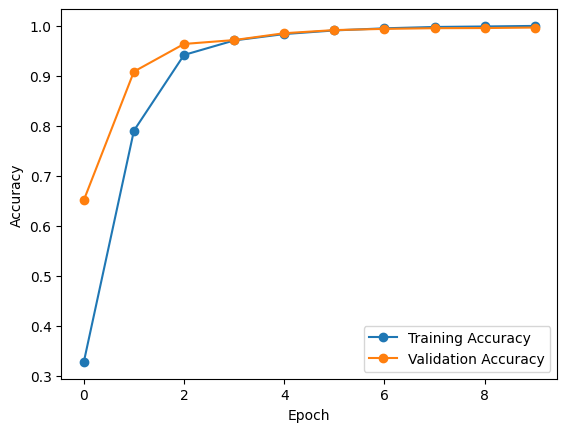

In [ ]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

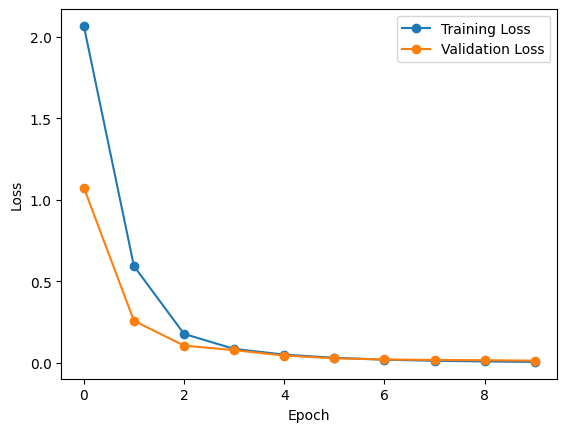

In [ ]:
# Loss plot
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [ ]:
patches = []
positions = []
height, width = y.shape
output_map = np.zeros((height, width))

margin = patch_size // 2
padded_X = pad_with_zeros(X_pca, margin)

for i in range(margin, padded_X.shape[0] - margin):
    for j in range(margin, padded_X.shape[1] - margin):
        if y[i - margin, j - margin] == 0:
            continue
        patch = padded_X[i - margin:i + margin + 1, j - margin:j + margin + 1, :]
        patches.append(patch)
        positions.append((i - margin, j - margin))

patches_array = np.array(patches)
predictions = model.predict(patches_array, verbose=1)

# Fill in output map
output_map = np.zeros((y.shape[0], y.shape[1]))
for pred, (i, j) in zip(predictions, positions):
    output_map[i, j] = np.argmax(pred) + 1


1692/1692 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [ ]:
# Class names (Salinas dataset)
class_names = [
    "Broccoli_green_weeds_1", "Broccoli_green_weeds_2", "Fallow",
    "Fallow_rough_plow", "Fallow_smooth", "Stubble", "Celery",
    "Grapes_untrained", "Soil_vinyard_develop", "Corn_senesced_green_weeds",
    "Lettuce_romaine_4wk", "Lettuce_romaine_5wk", "Lettuce_romaine_6wk",
    "Lettuce_romaine_7wk", "Vinyard_untrained", "Vinyard_vertical_trellis"
]
cmap = plt.cm.get_cmap('jet', 16)

legend_patches = [mpatches.Patch(color=cmap(i),label=class_names[i]) for i in range(16)]

<ipython-input-17-f89fe6165fed>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('jet', 16)


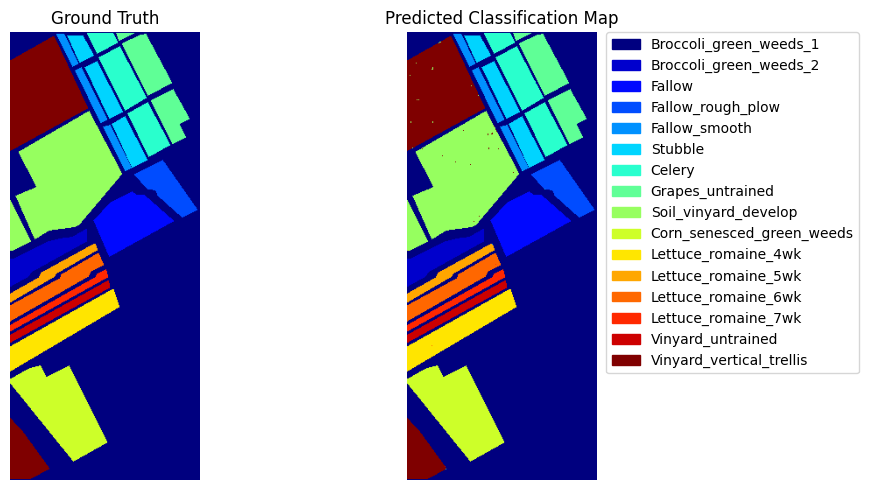

In [ ]:
plt.figure(figsize=(12, 5))

# Ground Truth
plt.subplot(1, 2, 1)
plt.imshow(y, cmap=cmap)
plt.title('Ground Truth')
plt.axis('off')

# Predicted Map
plt.subplot(1, 2, 2)
plt.imshow(output_map, cmap=cmap)
plt.title("Predicted Classification Map")
plt.axis('off')

# Legends
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()